<a href="https://colab.research.google.com/github/junhyeok8696/NLP/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer model for language understanding  

<img src=https://www.tensorflow.org/images/tutorials/transformer/transformer.png width=500>

# Transformer model 작성 from scratch

- Portugal - English translation model 작성

- text genertion 및 attention 이 선수 지식임  

- Transformer model 의 핵심 idea 는 self-attention  

- Transformer 는 self-attention layer 를 쌓아서 구성 (RNN, CNN 사용 않음)    
    - Scaled dot product attention
    <img src="https://www.tutorialexample.com/wp-content/uploads/2020/10/Scaled-Dot-Product-Attention.png" width="400" />
   
    - Multi-head attention
<img src="https://wikidocs.net/images/page/159310/mha_img_original.png" width="400" />
    

- stacked attention layer 의 장점  
    - data 간의 시간적, 공간적 관계를 배제하여 multi-processing 가능  
    - RNN, CNN layer 를 거치지 않아도, 떨어져 있는 item 들이 서로의 output 에 영향을 끼칠 수 있다.
    - 긴 문장내의 상호 관계를 학습할 수 있다. (모든 sequential task 의 도전 과제)  
    
- 단점  
    - 시계열 자료의 경우 RNN 처럼 특정 time-step 의 output 계산을 위해서는 input 과 현재의 hidden state 만으로는 안되고 전체 history 가 있어야 함
    - 단어의 위치 정보를 추가해 주어야 한다. (positional encoding)

이 노트에서 모델을 학습 한 후 포르투갈어 문장을 입력하고 영어 번역을 반환 할 수 있음.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" width="1000" alt="Attention heatmap">

In [1]:
!pip install tensorflow_datasets
!pip install -U tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 16.6 MB/s eta 0:00:00


In [2]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text as text

In [3]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

## Setup input pipeline

[TFDS](https://www.tensorflow.org/datasets) 를 이용하여 [TED Talks Open Translation Project](https://www.ted.com/participate/translate) 로 부터 [Portugese-English translation dataset](https://github.com/neulab/word-embeddings-for-nmt) 을 load.

dataset 은 약 50000 개의 training example 과 1100 개의 validation examples, 2000 개의 test example 로 구성


In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

print(examples)
print("=" * 80)
print(metadata)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete3FMW2Z/ted_hrlr_translate-trai…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete3FMW2Z/ted_hrlr_translate-vali…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete3FMW2Z/ted_hrlr_translate-test…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.
{Split('train'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>, Split('validation'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>, Split('test'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>}
tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    full_name='ted_hrlr_translate/pt_to_en/1.0.0',
    description="""
    Data sets derived from TED talk transcripts for comparing similar language pairs
    where one is high resource and the other is low resource.
    """,
    config_description="""
    Translation dataset from pt to en in plain text.
    """,
    homepage='https:/

In [5]:
for k, v in metadata.splits.items():
    print(k, v.num_examples)

train 51785
validation 1193
test 1803


- 이 데이터세트는 포르투갈어/영어 문장 쌍을 생성합니다

In [6]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
    for pt in pt_examples.numpy():
        print(pt.decode('utf-8'))

    print()

    for en in en_examples.numpy():
        print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


## Text tokenization & detokenization

텍스트를 embedding에 대한 인덱스인 토큰 ID 시퀀스로 변환합니다.

이 데이터 세트에 최적화된 subword tokenizer(text.BertTokenizer)를 빌드하고 저장된 모델로 내보냅니다.

Saved_model을 다운로드하고 압축을 풀고 가져옵니다.

tokenizer model 작성 과정은 [사용자 정의 tokenizer](https://www.tensorflow.org/text/guide/subwords_tokenizer) 참조

In [7]:
# 사전 훈련된 Subword Tokenizer download
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [8]:
tokenizers = tf.saved_model.load(model_name)

tf.saved_model에는 두 개의 텍스트 토크나이저가 포함되어 있습니다. 하나는 영어용이고 다른 하나는 포르투갈어용입니다. 둘 다 동일한 방법을 사용합니다.

In [9]:
tokenizers.en, tokenizers.pt

(<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7bcd8f771510>,
 <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7bcd8f771420>)

tokenizer에 포함된 method들은 다음과 같습니다.

In [10]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

tokenize 메서드는 문자열 배치를 토큰 ID의 padded batch로 변환합니다. 이 방법은 구두점, 소문자를 분할하고 토큰화하기 전에 입력을 유니코드로 정규화합니다.

detokenize 메서드는 tokenized ID를 사람이 읽을 수 있는 텍스트로 다시 변환 합니다.

In [11]:
for en in en_examples.numpy():
    print(en.decode('utf-8'))

print()
encoded = tokenizers.en.tokenize(en_examples)   # tokenize -> 텍스트 토큰화
for row in encoded.to_list():
    print(row)

print()
round_trip = tokenizers.en.detokenize(encoded)     # detokenize -> 텍스트 변환
for line in round_trip.numpy():
    print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


lookup method는 tokenized ID를 tokenized text로 변환합니다.

In [12]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

여기에서 토크나이저의 "subwords"를볼 수 있습니다. 예를 들어, "searchability"라는 단어는 "search ##ability"로, "serendipity"라는 단어는 "s ##ere ##nd ##ip ##ity"로 분해됩니다.

"Transformer is awesome."을 tokenize 하면 다음과 같습니다.

In [13]:
sample_string = tf.constant(['Transformer is awesome.'])

tokenized_string = tokenizers.en.tokenize(sample_string)

print(tokenized_string.numpy())
print(tokenizers.en.lookup(tokenized_string))
print(tokenizers.en.detokenize(tokenized_string).numpy())

[[   2 1761  227   80 1920   15    3]]
<tf.RaggedTensor [[b'[START]', b'transform', b'##er', b'is', b'awesome', b'.', b'[END]']]>
[b'transformer is awesome .']


## 입력 파이프라인 설정 - (1)
훈련에 적합한 입력 파이프라인을 구축하기 위해 데이터 세트에 몇 가지 변환을 적용합니다.

tensorflow model에 입력으로 사용하기 위해 원시 text의 비정형텐서(ragged tensor)를 tensor로 변환합니다.


In [14]:
print(tokenized_string)
print(tokenized_string.to_tensor())

<tf.RaggedTensor [[2, 1761, 227, 80, 1920, 15, 3]]>
tf.Tensor([[   2 1761  227   80 1920   15    3]], shape=(1, 7), dtype=int64)


In [15]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

다음은 데이터를 처리, 셔플 및 일괄 처리하는 간단한 입력 파이프라인입니다.

- train, validation batch pipeline 생성  
- tf.data.AUTOTUNE 은 작동하는 Network가 스스로 설정하고 Dataset을 잘 불러올 수 있게 결정하라는 것

In [16]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def make_batches(ds):
    return (
        ds                                                                                                # tfds
        .cache()                                                                                       # 캐시에 메모리상으로 저장
        .shuffle(BUFFER_SIZE)                                                              # 데이터를 섞어줌
        .batch(BATCH_SIZE)                                                                  # BATCH 단위 묶음
        .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE))                                                    # GPU에 load 하기전에 메모리에 올려놓음

train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)
train_batches, val_batches

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>)

validation set  에서 batch 를 하나 가져와 dataset pipeline 이 잘 구성 되었는지 조회 합니다.

In [17]:
pt_batch, en_batch = next(iter(val_batches))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 79), dtype=int64, numpy=
 array([[   2,  288, 1140, ...,    0,    0,    0],
        [   2,   40,  670, ...,    0,    0,    0],
        [   2,   91, 2825, ...,    0,    0,    0],
        ...,
        [   2,  106,  140, ...,    0,    0,    0],
        [   2,  158,  133, ...,    0,    0,    0],
        [   2,  113,  289, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 61), dtype=int64, numpy=
 array([[   2,  100,   37, ...,    0,    0,    0],
        [   2,   71, 1017, ...,    0,    0,    0],
        [   2,   78,   89, ...,    0,    0,    0],
        ...,
        [   2,  101,  169, ...,    0,    0,    0],
        [   2,  503,  110, ...,    0,    0,    0],
        [   2,   82,   76, ...,    0,    0,    0]])>)

## Positional encoding - (2)

 - 위치 인코딩이 추가되어 문장에서 단어의 상대 위치에 대한 정보를 모델에 제공

- positional encoding 벡터를 임베딩 벡터에 추가하면 d 차원 공간에서 단어의 의미와 문장에서의 위치의 유사성에 따라 단어가 서로 더 가깝게 된다.

- [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) 에서 자세한 내용 참조.
- 위치 인코딩을 계산하는 공식은 다음과 같다.

$${PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$${PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$
<div align="center">
<li>d_model : embedding vector 의 차원 (512)</li>
<li>pos : 입력문장의 단어 순서 위치 </li>
<li>i : embedding vector 내의 차원의 index</li>
</div>

In [18]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [19]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :], d_model)
  # 짝수 위치 (2i) 에는 sin 적용
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  # 홀수 위치 (2i) 에는 cos 적용
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  pos_encoding = angle_rads[np.newaxis, ...]
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


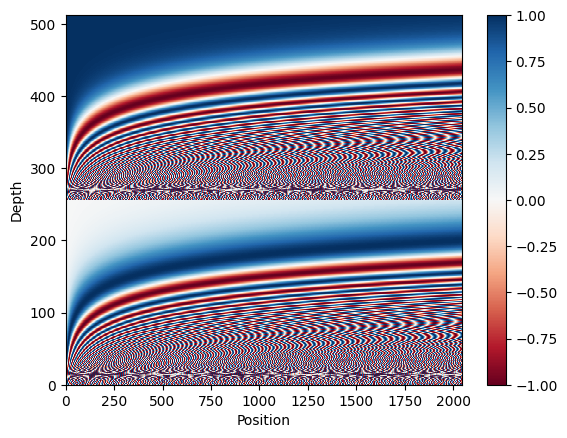

In [20]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Masking  - (3)

- 두가지 mask 생성
    - PAD mask : encoder, decoder 의 sequence batch 내의 `<PAD>` token 위치 표시
    - look ahead mask : decoder 에서 뒤쪽 단어를 보지 않기 위해 mask

#### PAD Mask
- sequence batch  내의 모든 패드 토큰 (0) 을 마스킹.
- 이렇게 하면 모델이 패딩을 입력으로 처리하지 않는다.
- 마스크는 패드 값 '0'이있는 위치를 나타낸다.
- 해당 위치에서 '1'을 출력하고 그렇지 않으면 '0'을 출력한다.

In [21]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)    # integer 0 을 float32 로 type 변환
    # attention logit 에 padding 을 더하기 위해 extra dimension 을  추가
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

상수 tensor 를 생성하여 위 함수를 Test  
- shape 이 (batch size, 1, 1, seq_len) 이고,
- 0 padding 위치가 1 로 masking 되었는지 확인

In [22]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

#### look-ahead 마스크
- sequence 의 뒤쪽(오른쪽) 토큰을 마스킹하는 데 사용.
- 즉, 마스크는 예측에 사용하지 말아야 할 단어를 표시
- 예를 들어 세 번째 단어를 예측하기 위해 첫 번째와 두 번째 단어 만 사용됨을 의미
- 네 번째 단어를 예측하려면 마찬가지로 첫 번째, 두 번째 및 세 번째 단어 만 사용

In [23]:
tf.linalg.band_part(tf.ones((4, 4)), -1, 0)  # Lower triangular part 를 남기고 1 로 변환

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]], dtype=float32)>

In [24]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask    # (seq_len, seq_len)

In [25]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention - (4)

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="400" alt="scaled_dot_product_attention">

- 트랜스포머에서 사용되는 attention 함수는 Q (query), K (key), V (value)의 세 가지 벡터를 입력으로 받는다.
- attention weight 를 계산하는 데 사용되는 공식은 다음과 같다.

$${Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

- dot-product attention 은 depth(embedding dimension) 의 제곱근에 의해 scaling 된다. scaling하는 이유는 큰 depth 값은 dot product 값을 크게 만들고 이 것을 소프트맥스 함수에 집어넣으면 기울기를 얻기 힘들게 되기 때문이다.
- 예를 들어, Q 와 K 가 표준 정규분포일 경우, matrix multiplication 은 평균 0, variance dk 가 되게 하므로 dk 의 제곱근으로 나누어주면 Q 와 K 의 matmul 은 평균 0, variance 1 이 되어 기울기를 구하기 쉽게 된다.

- mask 에 -1e9(음의 무한대에 가까움) 을 곱하여 Q와 K의 스케일 된 행렬 곱셈 (scaled-attention-logit) 에 더한다.  이렇게 하면 mask 가 1 인 경우는 softmax 에 큰 음의 입력값을 주게 되고 출력이 0 이 되도록 한다.
즉, mask 가 1 인 경우는 예측을 하면 안되기 때문이다.

- softmax를 거친 값을 value에 곱해준다면, query와 유사한 value일수록, 즉 중요한 value일수록 더 높은 값을 가지게 된다. 중요한 정보에 더 관심을 둔다는 attention의 원리에 알맞은 것임.

In [26]:
def scaled_dot_product_attention(q, k, v, mask):
  """attention weights 계산
  q, k, v 의 첫번째 dimension(batch size) 은 같아야 함
  k, v 의  끝에서 두번째 dimension 은 같아야 함. 즉, seq_len_k = seq_len_v.
  mask 는 padding mask 인지 look ahead mask 인지에 따라 다른 shape 을 가진다.
        padding - (batch_size, 1, 1, seq_len), look ahead - (seq_len, seq_len)
  그러나 addition 할 때에는  broadcasting 이 발생한다.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # shape (..., seq_len_q, seq_len_k), k 를 transpose

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # scaled_attention_logit 에 (mask * -1e9) 를 더하여 padding 위치 (masked 1) 의 값이 0 이 되도록 함
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # last axis (seq_len_k) 를 기준으로 softmax normalize 되어 scores 의 합이 1 이 되도록 함.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

- K 에 대하여  softmax normalization 을 하였으므로 K 의 value (V) 는 Q 에 대해 얼마나 K 가 중요한지를 결정하게 된다.
- 위 함수에서 return 된 output 은 attention weight 와 V (value) vector 의 matmul 인데, 이 것은 주목할 단어를 그대로 보존하고, 무관한 단어를 지워버리는 역할을 한다.

In [27]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

- scaled dot attention test

In [28]:
np.set_printoptions(suppress=True)
# key
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3) [The, big, red, dog]
# value
temp_v = tf.constant([[1, 0],
                      [10, 0],    # A
                      [100, 5],
                      [1000,6]], dtype=tf.float32)  # (4, 2) embedding dim = 2
# query
# 두번째 key([0, 10, 0])를 query 하면
# 두번째 value([10, 0]) 가 attention weight 1 로 반환됨
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)  big
print_out(temp_q, temp_k, temp_v)   #output [0, 1, 0, 0] 은 A 만 남고 나머지는 지워지는 결과

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [29]:
# 세번째 key 를 query 하면 세번째 value가 attentin weight 1 로 반환되고
# 같은 값을 갖는 두 key값의 평균을 반환([100, 5] 와 [1000, 6] 의 평균인 [550, 5.5])
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [30]:
# 이 query 는 첫번째와 두번째 key를 동등하게 query 하므로, 평균값 반환
# [1, 0] 와 [10, 0] 의 평균값인 [5.5, 0]
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


위의 세가지 쿼리를 한번에 행렬연산. 동일한 값이 출력됨을 확인.

In [31]:
temp_q = tf.constant([[0, 10, 0], [0, 0, 10], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  1.  0.  0. ]
 [0.  0.  0.5 0.5]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[ 10.    0. ]
 [550.    5.5]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention - (5)

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


멀티 헤드 attention 은 다음 네 부분으로 구성된다.
* linear layer 와 헤드 분할.
* scaled dot-product attention.
* multi-head 의 concatenate.
* 최종 linear layer.

각 멀티 헤드 어텐션 블록에는 Q (쿼리), K (키), V (값) 의 3 개의 입력이 있다. 이들은 선형 (Dense) 레이어를 통해 여러 헤드로 분할된다.

위에서 정의한`scaled_dot_product_attention` 을 각 헤드에 적용.(효율성을 위해 broadcast 됨). attention 단계에서 적절한 마스크를 사용해야 한다. 그런 다음 각 헤드에 대한 attention output 이 연결되고 (`tf.transpose` 및 `tf.reshape` 사용) 최종 `Dense` 레이어를 통과.

하나의 단일 attention head 를 사용 않고, Q, K 및 V는 여러 헤드로 분할되어 모델이 서로 다른 표현 공간의 다른 위치에있는 정보에 공동으로 attend 할 수 있게한다. 분할 후 각 헤드의 dimension 이 감소하므로 전체 계산 비용은 전체 dimension 으로 단일 head attention 할 때와 같다.

- Subclass API

In [32]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    # Linear Layer
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """ last dimension 을 (num_heads, depth) 로 split.
        shape 이 (batch_size, num_heads, seq_len, depth) 가 되도록 결과를 transpose
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape  == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention,
                       perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

`x`  시퀀스의 각 위치에서 `MultiHeadAttention` 은 시퀀스의 다른 모든 위치에 8 개의 attention head 를 모두 실행하여 해당 위치에서 동일한 길이의 새 output 벡터를 반환.

In [33]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
x = tf.random.uniform((1, 50, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(x, k=x, q=x, mask=None)
out.shape, attn.shape

(TensorShape([1, 50, 512]), TensorShape([1, 8, 50, 50]))

## Point wise feed forward network - (6)

Pointwise feed forward network 은 ReLU 활성화를 통해 두 개의 완전히 연결층으로 구성된다.

In [34]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),   # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)                   # (batch_size, seq_len, d_model)
  ])

In [35]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(out).shape

TensorShape([1, 50, 512])

## Encoder and decoder
<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

transformer model 은  표준 `sequence to sequence with attention model` 과 동일한 일반적 pattern 을 따른다.

* 입력 문장은 시퀀스의 각 단어 / 토큰에 대한 출력을 생성하는 N 개의 인코더 레이어를 통과한다.
* 디코더는 다음 단어 예측을 위해 인코더의 출력과 자체의 입력 (self-attention)에 attend 한다.

### Encoder layer - (7)

각 encoder layer 는 sublayer 들로 구성:

1.   Multi-head attention (with padding mask)
2.   Point wise feed forward networks.

이들 서브 계층들 각각은 그 주변을 돌아가는 residual connection(잔차 연결)을 갖고 있어서 layer normalization 을 한다. 잔차 연결은 딥 네트워크에서의 vanishing gradient 문제를 방지하는 데 도움이 된다.

각 sublayer 의 output 은 `LayerNorm(x + Sublayer(x))` 이다. normalization 은 `d_model` (last) axis 에 대해 이루어 진다. transformer 는 N encoder layer 로 구성된다.

In [36]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [37]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)
x = tf.random.uniform((64, 43, 512))

sample_encoder_layer_output = sample_encoder_layer(x, False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer - (8)

각 decoder layer 는 다음의 sublayer 들로 구성:

1.   Masked multi-head attention (look ahead mask 와 padding mask 로 구성)
2.   Multi-head attention (with padding mask).
    - encoder 로부터 V (value) and K (key) 의 *encoder output* 을 inputs 으로 받는다.
    - Q (query) 는  *masked multi-head attention sublayer 의 output* 을 input 으로 받는다.
3.   Point wise feed forward networks

이들 서브 계층들 각각은 그 주변에 residual connection(잔차 연결) 을 갖고 이어서 layer normalization dmf 갖는다. 각 sublayer 의 output 은 `LayerNorm(x + Sublayer(x))` 이다. normalization 은 d_model (last) axis 에 대해 이루어 진다.

N decoder layer 로 구성된다.

Q는 디코더의 첫 번째 attention 블록에서 출력을 수신하고 K가 인코더 출력을 수신함에 따라 attention weight 는 인코더의 출력을 기반으로 디코더의 입력에 주어진 중요성을 나타낸다. 다시 말해, 디코더는 엔코더의 출력을보고 자체 출력에 self attention 하여 다음 단어를 예측한다.


In [38]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 \
            = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 \
            = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)           # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [39]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

x = tf.random.uniform((64, 50, 512))

sample_decoder_layer_output, _, _ \
        = sample_decoder_layer(x, sample_encoder_layer_output, False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder 전체 - (9)

전체 `Encoder` 는 다음으로 구성:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

입력은 positional 인코딩과 합쳐진 임베딩을 통해 이루어진다. 이 합산의 출력은 인코더 계층에 대한 입력이다. 인코더의 출력은 디코더에 대한 입력이다.

In [40]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

    self.enc_layers \
          = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
        x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [41]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
x = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(x, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder 전체 - (10)

전체 `Decoder` 는 다음으로 구성:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

타겟은 positional 인코딩과 합산 된 임베딩을 통해 이루어진다. 이 합산의 출력은 디코더 층에 대한 입력이다. 디코더의 출력은 최종 linear layer 에 대한 입력이다.

In [42]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers \
         = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 \
        = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [43]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)

x = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(x,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Transformer 생성 - (11)

Transformer 는 인코더, 디코더 및 최종 linear layer 로 구성. 디코더의 출력은 linear layer 에 대한 입력이며 출력이 반환된다.

In [44]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    inp, tar = inputs

    enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [45]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Set hyperparameters

이 예제를 작고 비교적 빠르게 유지하기 위해 *num_layers, d_model 및 dff* 의 값을 줄임.

transformer  기본 모델에 사용 된 값은; *num_layers=6*, *d_model = 512*, *dff = 2048*.

참고 : 아래 값을 변경하면 많은 작업에서 최첨단 모델을 얻을 수 있다.

In [46]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## Optimizer

[paper](https://arxiv.org/abs/1706.03762) 의 공식에 따라 custom learning rate scheduler 와 함께 Adam optimizer 를 사용한다.



$${lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [47]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [48]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

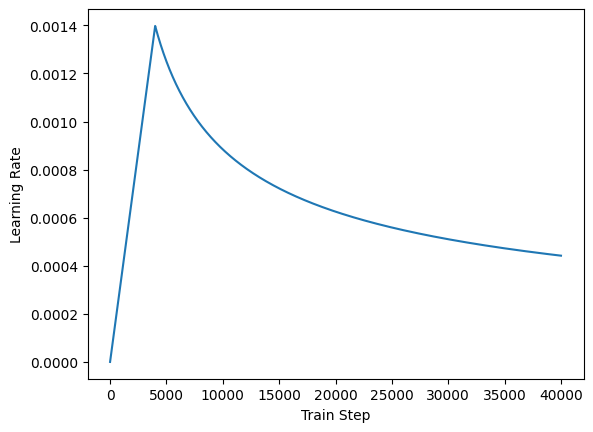

In [49]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

target sequences 가 padding 되어 있으므로, loss 계산 시 `padding mask` 를 적용하는 것이 중요.

`tf.keras.losses.SparseCategoricalCrossentropy` 의 reduction=NONE 으로 지정할 경우는 shape 이 `[batch_size, d0, .. dN-1]` 이고, 그렇지 않은 경우는 scalar 이다.

In [50]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=True, reduction='none')

In [51]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [52]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

# Training and checkpointing

## Transformer model 생성

In [53]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [54]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

- target 은 tar_inp와 tar_real로 나뉜다.
- tar_inp 은 디코더에 입력으로 전달된다. tar_real은 동일한 입력이 1 step 만큼 이동 된 것이다. tar_input 의 각 위치에서 tar_real은 예측해야 할 다음 토큰을 포함한다.
```
    sentence = "SOS A lion in the jungle is sleeping EOS"
    tar_inp =  "SOS A lion in the jungle is sleeping"
    tar_real = "A lion in the jungle is sleeping EOS"
```
- training은 teacher-forcing 기법 사용 (teacher-forcing 은 현재 time step 에서 모델이 예측하는 것과 상관없이 실제 출력을 다음 time step 으로 전달)

- Inference 단계에서 Transformer 는 자동 회귀 모델이다. 한 번에 한 부분 씩 예측하고 그 결과를 사용하여 다음 token을 예측. Transformer 가 각 단어를 예측할 때 *self-attention* 을 사용하면 입력 시퀀스의 이전 단어를보고 다음 단어를 더 잘 예측할 수 있다.

- model 이 expected output 을 미리 엿보는 것을 막기 위해 look-ahead mask 사용.

In [55]:
EPOCHS = 20

In [56]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

### Portugal 어가 input language 이고 English 가 target language 로 사용됨.

- Colab GPU 약 20 분 이상 소요

In [57]:
import time
s = time.time()

for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.8563 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.7883 Accuracy 0.0049
Epoch 1 Batch 100 Loss 8.6923 Accuracy 0.0275
Epoch 1 Batch 150 Loss 8.5830 Accuracy 0.0349
Epoch 1 Batch 200 Loss 8.4430 Accuracy 0.0395
Epoch 1 Batch 250 Loss 8.2730 Accuracy 0.0454
Epoch 1 Batch 300 Loss 8.0810 Accuracy 0.0536
Epoch 1 Batch 350 Loss 7.8835 Accuracy 0.0614
Epoch 1 Batch 400 Loss 7.6948 Accuracy 0.0688
Epoch 1 Batch 450 Loss 7.5269 Accuracy 0.0759
Epoch 1 Batch 500 Loss 7.3786 Accuracy 0.0830
Epoch 1 Batch 550 Loss 7.2425 Accuracy 0.0903
Epoch 1 Batch 600 Loss 7.1153 Accuracy 0.0981
Epoch 1 Batch 650 Loss 6.9978 Accuracy 0.1051
Epoch 1 Batch 700 Loss 6.8911 Accuracy 0.1114
Epoch 1 Batch 750 Loss 6.7895 Accuracy 0.1174
Epoch 1 Batch 800 Loss 6.6952 Accuracy 0.1232
Epoch 1 Loss 6.6800 Accuracy 0.1241
Time taken for 1 epoch: 163.98 secs

Epoch 2 Batch 0 Loss 5.1959 Accuracy 0.2128
Epoch 2 Batch 50 Loss 5.1806 Accuracy 0.2186
Epoch 2 Batch 100 Loss 5.1580 Accuracy 0.2217
Epoch 2 Batch

In [58]:
print("Total elapsed : {:.2f} 분".format((time.time() - s) / 60))

Total elapsed : 33.42 분


## 추론 실행
추론에는 다음 단계가 사용됩니다.

- 포르투갈어 토크나이저(tokenizers.pt)를 사용하여 입력 문장을 인코딩합니다. 인코더 입력입니다.

- 디코더 입력은 [START] 토큰으로 초기화됩니다.

- 패딩 마스크와 look ahead mask를 계산합니다.

- 그런 다음 디코더는 인코더 출력과 자체 출력(셀프 어텐션)을 확인하여 예측을 출력합니다.

- 예측된 토큰을 디코더 입력에 연결하고 디코더에 전달합니다.

- 이 접근 방식에서 디코더는 예측한 이전 토큰을 기반으로 다음 토큰을 예측합니다.

In [59]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=20):
    # 입력 문장은 포르투갈어이므로 시작 및 종료 토큰을 추가합니다.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # 대상이 영어이므로 transformer에 대한 첫 번째 토큰은 english start 토큰이어야 합니다.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # 동적 루프가 `tf.function`에 의해 추적될 수 있도록 `tf.TensorArray`가 (파이썬 list 대신) 필요합니다.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # seq_len dimension에서 last token을 선택합니다.
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.argmax(predictions, axis=-1)

      # 디코더에 input으로 제공되는 output에 predicted_id를 concatenate합니다.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # output.shape (1, tokens)
    text = tokenizers.en.detokenize(output)[0]  # shape: ()

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function`은 루프의 마지막 iteration에서 계산된 Attention_weights를 사용하지 못하게 합니다.
    # 따라서 loop 외부에서 다시 계산합니다.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

이 Translator 클래스의 인스턴스를 만들고 몇 번 시도해 봅니다.

In [60]:
translator = Translator(tokenizers, transformer)

In [61]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [62]:
sentence = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to fix .
Ground truth   : this is a problem we have to solve .


In [63]:
sentence = "os meus vizinhos ouviram sobre esta ideia."
ground_truth = "and my neighboring homes heard about this idea ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


## Attention plots

Translator 클래스는 모델의 내부 작업을 시각화하는 데 사용할 수 있는 어텐션 맵의 dictionary를 반환합니다.

In [64]:
sentence = "vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."
ground_truth = "so i \'ll just share with you some stories very quickly of some magical things that have happened ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to be very quickly share with you some of the bad stories that happen .
Ground truth   : so i 'll just share with you some stories very quickly of some magical things that have happened .


In [65]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # 토큰이 생성되었을 때의 attention을 plot 합니다.
  # 모델이 출력에서 `<START>`를 생성하지 않았습니다. skip 합니다.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [66]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([20, 20])

In [67]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(20,), dtype=string, numpy=
array([b'[START]', b'vou', b'entao', b'muito', b'rapidamente',
       b'partilhar', b'convosco', b'algumas', b'historias', b'de',
       b'algumas', b'coisas', b'ma', b'##gica', b'##s', b'que',
       b'acontecera', b'##m', b'.', b'[END]'], dtype=object)>

In [68]:
translated_tokens

<tf.Tensor: shape=(21,), dtype=string, numpy=
array([b'[START]', b'so', b'i', b"'", b'm', b'going', b'to', b'be',
       b'very', b'quickly', b'share', b'with', b'you', b'some', b'of',
       b'the', b'bad', b'stories', b'that', b'happen', b'.'], dtype=object)>

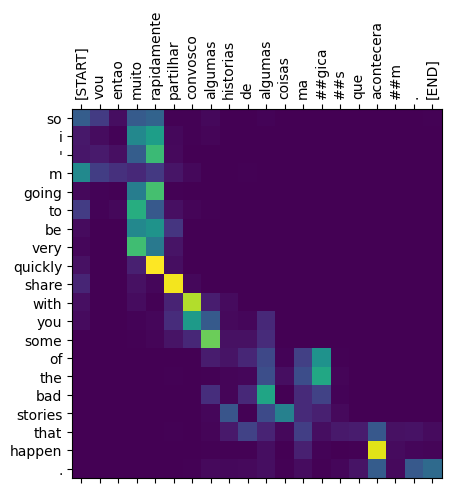

In [69]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [70]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

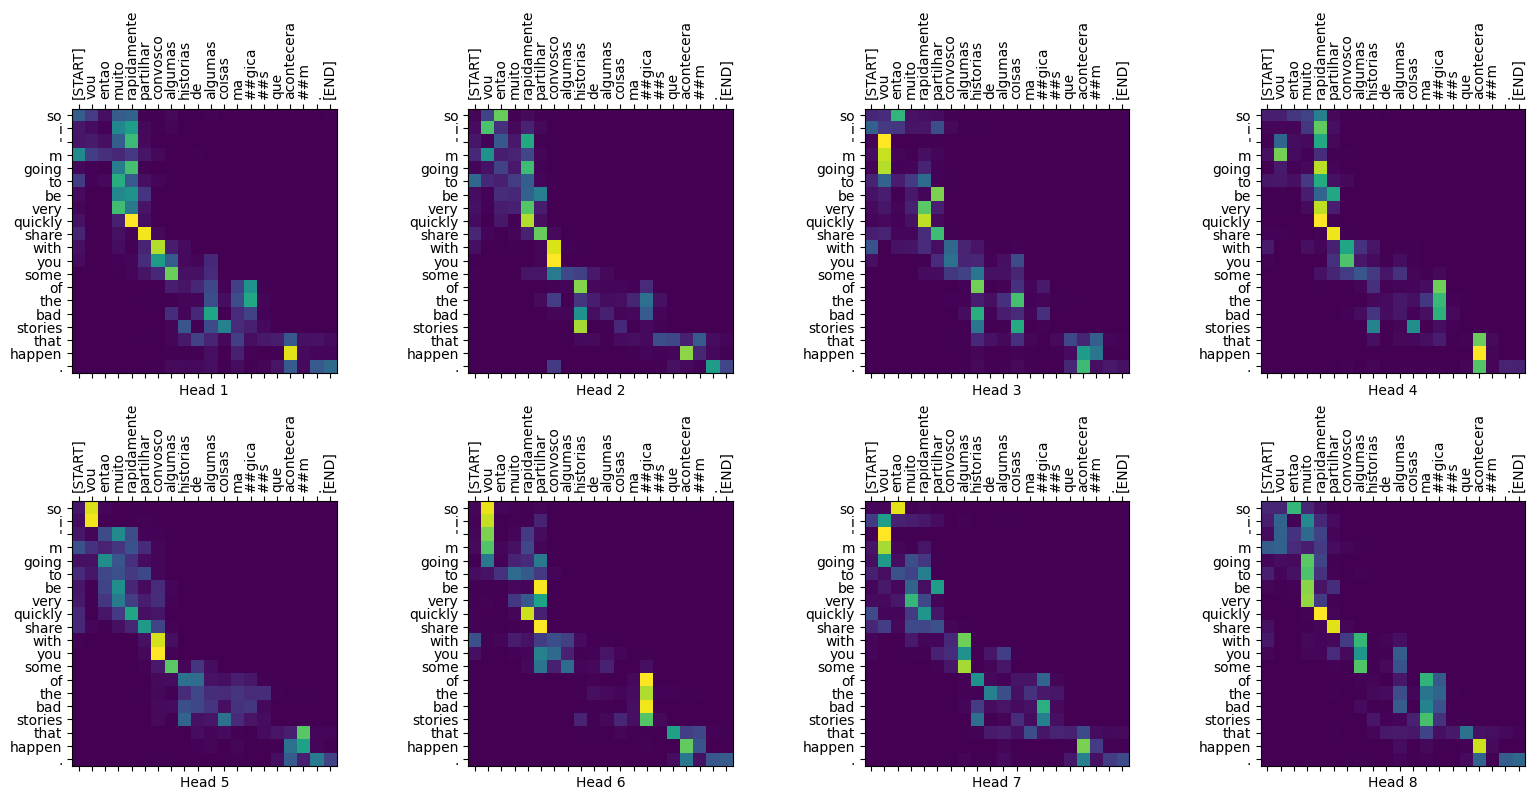

In [71]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

모델은 익숙하지 않은 단어에 대해서도 괜찮아 보입니다. "triceratops" 또는 "encyclopedia"는 입력 데이터 세트에 없으며 모델은 공유 어휘 없이도 거의 음역(소리나는대로 번역)하는 방법을 학습합니다.

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about trieass in encyclopedia .
Ground truth   : I read about triceratops in the encyclopedia.


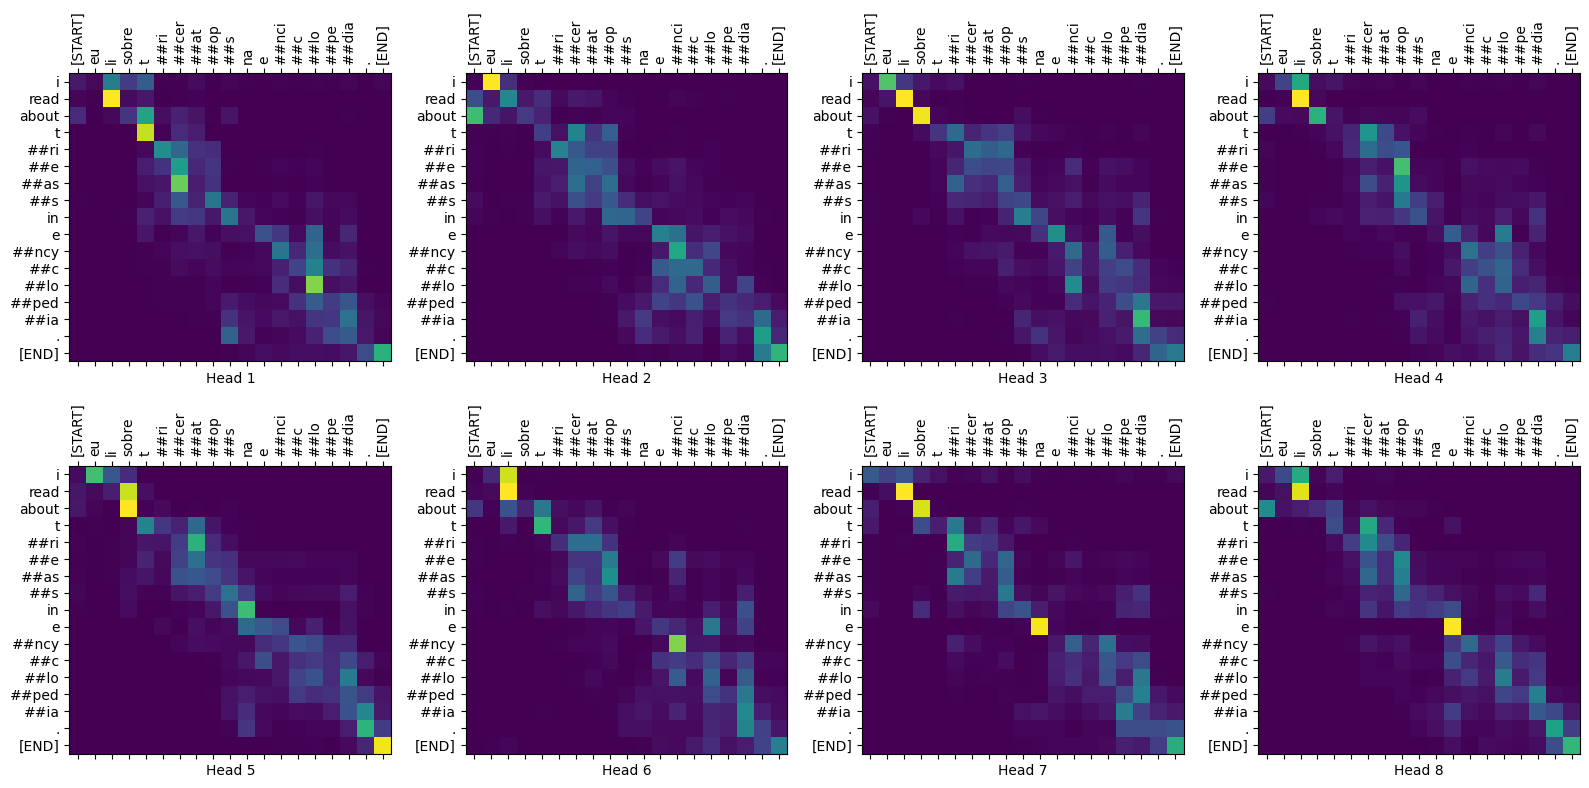

In [72]:
sentence = "Eu li sobre triceratops na enciclopédia."
ground_truth = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

## Export

해당 추론 모델이 작동하고 있으므로 다음에는 이를 tf.saved_model로 내보냅니다.

그렇게 하려면 이번에는 __call__ 메서드에 tf.function을 사용하여 또 다른 tf.Module 하위 클래스로 래핑합니다.

In [73]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=100)

    return result

위의 tf.function에서는 출력 문장만 반환됩니다. tf.function의 엄격하지 않은 실행 덕분에 불필요한 값은 절대 계산되지 않습니다.

In [74]:
translator = ExportTranslator(translator)

모델이 tf.argmax를 사용하여 예측을 디코딩하기 때문에 예측은 결정적(deterministic)입니다. 원래 모델과 저장된 모델에서 다시 로드된 모델은 동일한 예측을 제공해야 합니다.

In [75]:
translator("este é o primeiro livro que eu fiz.").numpy()

b'this is the first book i did .'

In [76]:
tf.saved_model.save(translator, export_dir='translator')

In [77]:
reloaded = tf.saved_model.load('translator')

In [78]:
reloaded("este é o primeiro livro que eu fiz.").numpy()

b'this is the first book i did .'